# Get all vessels and filter on client side

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
signal_ocean_api_key = '777604c89c534dd7a9a3ab3e055321c5' #replace with your subscription key

In [2]:
from datetime import date, timedelta,time
from signal_ocean import PortAPI, VesselClassAPI,PortFilter,VesselClassFilter,Connection
from signal_ocean.historical_tonnage_list import VesselFilter, PushType, MarketDeployment, CommercialStatus, VesselSubclass
from signal_ocean.historical_tonnage_list import HistoricalTonnageListAPI

connection = Connection(signal_ocean_api_key)

port_api = PortAPI(connection)
vessel_class_api = VesselClassAPI(connection)
htl_api = HistoricalTonnageListAPI(connection)
vessel_class = vessel_class_api.get_vessel_classes(VesselClassFilter(name_like='vlcc'))[0]
port = port_api.get_ports(PortFilter(name_like='escravos'))[0]
laycanEndInDays = 1000
start_date = date(2020, 1, 1)
end_date = date(2020, 4, 1)

vessel_filter = VesselFilter(
    vessel_subclass=VesselSubclass.DIRTY
)


htl_for_supply_trend = htl_api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycanEndInDays,
    start_date,
    end_date,
    time=time(hour=6)
)

supply_trend_data_frame = htl_for_supply_trend.to_data_frame()

supply_trend_data_frame

name vessel_class ice_class  \
date                      imo                                              
2020-04-01 06:00:00+00:00 9212888            Hedy         VLCC       NaN   
                          9218492        Deep Sea         VLCC       NaN   
                          9362073         Hero II         VLCC       NaN   
                          9212890           Halti         VLCC       NaN   
                          9218466           Dover         VLCC       NaN   
...                                           ...          ...       ...   
2020-01-01 06:00:00+00:00 9683697   Vl Prosperity         VLCC       NaN   
                          9597264    Eagle Verona         VLCC       NaN   
                          9732541            Aral         VLCC       NaN   
                          9288095      New Spirit         VLCC       NaN   
                          9468853  Olympic Target         VLCC       NaN   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2020-04-01 06:00:00+00:00 9212888        2002      299242          333.00   
                          9218492        2004      296977          333.62   
                          9362073        2007      317355          333.00   
                          9212890        2002      299261          334.50   
                          9218466        2003      296977          333.50   
...                                       ...         ...             ...   
2020-01-01 06:00:00+00:00 9683697        2015      319547          333.00   
                          9597264        2013      320122          333.00   
                          9732541        2016      299011          333.00   
                          9288095        2005      298972          330.00   
                          9468853        2011      319869          339.76   

                                   breadth_extreme subclass  \
date                      imo                                 
2020-04-01 06:00:00+00:00 9212888               58    Dirty   
                          9218492               58    Dirty   
                          9362073               60    Dirty   
                          9212890               58    Dirty   
                          9218466               58    Dirty   
...                                            ...      ...   
2020-01-01 06:00:00+00:00 9683697               60    Dirty   
                          9597264               60    Dirty   
                          9732541               60    Dirty   
                          9288095               60    Dirty   
                          9468853               60    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2020-04-01 06:00:00+00:00 9212888                        Contract   
                          9218492                        Contract   
                          9362073                        Contract   
                          9212890                            Spot   
                          9218466                        Contract   
...                                                           ...   
2020-01-01 06:00:00+00:00 9683697                         Program   
                          9597264                         Program   
                          9732541                            Spot   
                          9288095                        Contract   
                          9468853                         Program   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2020-04-01 06:00:00+00:00 9212888              Not Pushed  ...   
                          9218492              Not Pushed  ...   
                          9362073              Not Pushed  ...   
      

Now, we can generate the plot:

<AxesSubplot:xlabel='date', ylabel='Vessel count'>

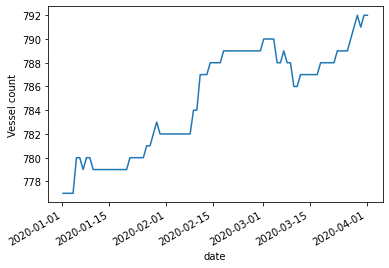

In [3]:
from signal_ocean.historical_tonnage_list import IndexLevel

supply_trend = supply_trend_data_frame.groupby(IndexLevel.DATE, sort=True).size()
plot = supply_trend.plot()
plot.set_ylabel('Vessel count')

plot

Prepare various filters and filter on client side

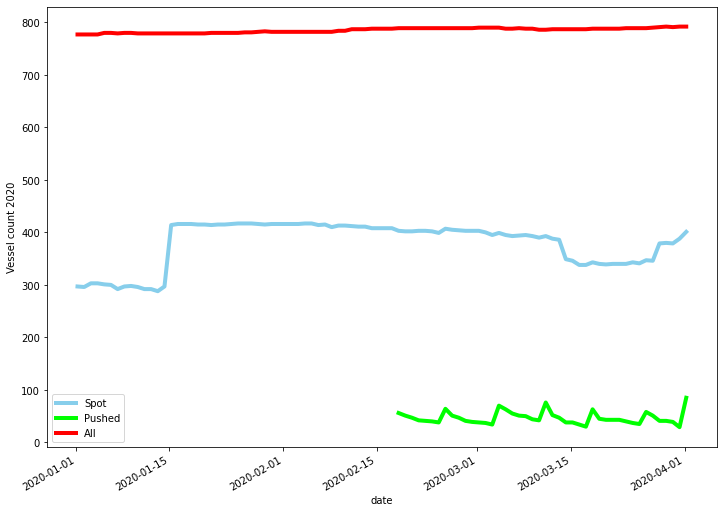

In [4]:
spot_filter = supply_trend_data_frame.market_deployment_point_in_time == MarketDeployment.SPOT
relet_filter = supply_trend_data_frame.market_deployment_point_in_time == MarketDeployment.RELET
pushed_filter = supply_trend_data_frame.push_type_point_in_time == PushType.PUSHED

spot_vessels = supply_trend_data_frame[spot_filter | relet_filter].groupby(IndexLevel.DATE, sort=True).size()
pushed_vessels = supply_trend_data_frame[pushed_filter].groupby(IndexLevel.DATE, sort=True).size()



ax = spot_vessels.plot(markerfacecolor='blue', color='skyblue', linewidth=4, label='Spot', figsize=(12, 9))
ax2 = pushed_vessels.plot(ax=ax, markerfacecolor='darkgreen', color='lime',linewidth=4, label='Pushed', figsize=(12, 9))
ax2 = supply_trend.plot(ax=ax, markerfacecolor='darkgreen', color='red',linewidth=4, label='All', figsize=(12, 9))

ax2.set_ylabel('Vessel count 2020')
ax2.legend()

In [5]:
from signal_ocean.historical_tonnage_list import Column

without_time_zones = (
    pushed_vessels
        .reset_index()
        .astype({ IndexLevel.DATE: 'datetime64[ns]'})
        .set_index([IndexLevel.DATE])
 )

without_time_zones.to_excel('simpleDemo2018.xlsx')